<a href="https://colab.research.google.com/github/savula13/ProjectsInMLandAI/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

**Final Project: Treatment Price Prediction**

*   By: Sai Avula & Srishti Pithadia
*   Date: December 1st, 2022

---


**Task 1: Describe the Problem**

The goal of this project is to examine the relationship between the prices of a specific treatments at different hospitals (with coverage under Medicare or Medicaid). We hope to determine whether some factors are more important than others in determining the cost of treatment (for example, maybe location), and if these observations will ultimately allow us to predict the cost of a certain treatment. This is a problem that can be solved with machine learning/artificial intelligence because it fits the requirements for using a neural network. There are 500,000+ data points available to analyze and there’s also 10+ input features. Additionally, the target variable (the price of treatment) is a continuous variable, making this a complex problem to solve and an ideal application of a neural network for making predictions.

**Task 2: Pick the Dataset**

In [2]:
# installing necessary resources
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 9.8 MB/s 
     |████████████████████████████████| 1.6 MB 15.4 MB/s 


In [3]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import random
import math
import pickle

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from tensorflow import keras
from keras.losses import MeanSquaredLogarithmicError, MeanSquaredError
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from keras import Sequential
from keras.layers import Dense, Dropout
from sklearn import model_selection as ms
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from google.colab import drive

# connect to Google Drive where compressed dataset has been uploaded
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


Mounted at /content/gdrive


We found the dataset at the following link:
[https://www.kaggle.com/datasets/natesutton/hospitalpricetransparency?select=price.csv](https://www.kaggle.com/datasets/natesutton/hospitalpricetransparency?select=price.csv)

We chose this dataset because it's relevant to our problem, and it's specific enough to hopefully yield a good accuracy score. By focusing on only the state of North Carolina, the data is not noisy and cluttered with more information than we can handle. This was the issue with the first dataset we originally selected:
[https://www.kaggle.com/datasets/jpmiller/healthcare?select=hospital_prices.csv](https://www.kaggle.com/datasets/jpmiller/healthcare?select=hospital_prices.csv)

It was 32GB and more than we could handle. It was such a struggle to get it to even just open in Colab! From this experience though, we revised our original plan and decided to focus on a particular region. In this case, our dataset would represent North Carolina. Additionally, this dataset is even better than others we looked at because instead of using 2 different categorization formats (HCPCS and CPT, which we'll go into more later), this dataset only uses the HCPCS format. Less to translate means less unnecessary data that needs to be loaded in and then removed later.

In [4]:
# unzip the compressed dataset
!unzip gdrive/My\ Drive/hospital_price_data.zip

Archive:  gdrive/My Drive/hospital_price_data.zip
  inflating: concept.csv             
  inflating: hospital.csv            
  inflating: price.csv               


In [6]:
# load up dataset #1
df1 = pd.read_csv('concept.csv')

# viewing the first few rows of the data
print(df1.shape)
df1.head()

(10793, 4)


,concept_id,concept_code,vocabulary_id,concept_name
0,43533189,CH,HCPCS,"0 percent impaired, limited or restricted"
1,43533250,CN,HCPCS,"100 percent impaired, limited or restricted"
2,40664799,G8707,HCPCS,"12-lead electrocardiogram (ecg) not performed,..."
3,40664798,G8704,HCPCS,12-lead electrocardiogram (ecg) performed
4,40218804,U0002,HCPCS,"2019-ncov coronavirus, sars-cov-2/2019-ncov (c..."


This dataset represents the Athena identifier as "concept_id", the source code as "concept_code", whether it's HCPCS or CPT as "vocabulary_id", and the human-readable name as "concept_name". 

HCPCS stands for "Healthcare Common Procedure Coding System Codes" and CPT stands for "Current Procedural Terminology". These lists identify all items/services that are included within certain DHS (Demographic & Health Survey) categories, as well as those that may qualify for certain exceptions. The DHS categories that are included in these lists are the following:

1. Clinical Laboratory Services
2. Physical Therapy Services
3. Occupational Therapy Services
4. Outpatient Speech-Language Pathology Services
5. Radiology/Other Imaging Services
6. Radiation Therapy Services/Supplies
7. Durable Medical Equipment/Supplies
8. Parenteral/Enteral Nutrients/Equipment/Supplies
9. Prosthetics, Orthotics, and Prosthetic Devices/Supplies
10. Home Health Services
11. Outpatient Prescription Drugs
12. Inpatient/Outpatient Hosptial Services

And the exceptions mentioned above fall within the following categories:
1. EPO & Other Dialysis-Related Drugs
2. Preventative Screening Tests/Vaccines

This information is outlined [here](https://www.cms.gov/medicare/fraud-and-abuse/physicianselfreferral/list_of_codes) at the CMS (Centers for Medicare & Medicaid Services) website. They are the organization that requires hospitals to publish lists of prices on their websites. Unfortunately though, the CMS doesn't have strong guidance on formatting (which is why HCPCS and CPT both exist simultaneously). Hospital pricing is then cluttered with noise purposfully introduced by hospital systems to be not consumer friendly.

In [7]:
# load up dataset #2
df2 = pd.read_csv('hospital.csv')

# viewing the first few rows of the data
print(df2.shape)
df2.head()

(115, 8)


,hospital_id,hospital_name,hospital_npi,city,state,critical_access_ind,affiliation,disclosure
0,1,CarolinaEast Medical Center,1801852835,New Bern,NC,0,Independent,https://apps.para-hcfs.com/PTT/FinalLinks/Caro...
1,2,Carteret Health Care,1760479331,Morehead City,NC,0,Independent,https://www.carterethealth.org/documents/conte...
2,3,Catawba Valley Medical Center,1164495255,Hickory,NC,0,Independent,https://www.catawbavalleyhealth.org/documents/...
3,4,Dosher Memorial Hospital,1326589649,Southport,NC,1,Independent,NaN
4,5,Granville Medical Center,1326061730,Oxford,NC,0,Independent,https://www.ghshospital.org/Content/Uploads/Gr...


This next dataset contains the name of the hospital as "hospital_name", their NPI (National Provider Identifier) as "hospital_npi", their city and state, whether they're critical access hospitals as "critical_access_ind", their group as "affiliation", and their disclosure as "disclosure".

The NPI is a HIPAA administration simplification standard, and is a unique ID number for covered health care providers. A critical access hospital is a desigation that reduces the financial vulnerability of rural hospitals to improve access to healthcare. They receive benefits like cost-based reimbursement for Medicare services. Affiliation refers to the group the hospital belongs to. Some hospitals can be independent, while a certian hospital group refers to the facilities/assets/operations all of acquired entities that are related to a hospital. Finally, a disclosure outlines how a hospital handles a patient's information.  

In [8]:
# load up dataset #3
df3 = pd.read_csv('price.csv')

# viewing the first few rows of the data
print(df3.shape)
df3.head()

(1507795, 4)


,hospital_id,concept_id,price,amount
0,1,2101826,gross,6147.00
1,1,2101827,gross,9221.00
2,1,40757009,gross,13614.00
3,1,40756966,gross,16559.00
4,1,32598,gross,10.69


This final dataset contains the price type of the service as "price", and the cost of the service (in USD) as "amount".

There are 4 options for the "price" column, which are the following:

1. Gross
2. Cash
3. Max Negotiated Rate
4. Min Negotiated Rate

The "gross" price type is often the top line item that the hospital never actually charges. The "cash" price type is the self-pay discounted price one would pay without insurance. The "max negotiated rate" price type is the maximum negotiated rate by an insurance company in the hospital network. Finally, the "min negotiated rate" price type is the minimum negotiated rate by an insurance company in the hospital network.

**Task 3: Prepare the Dataset**

In [9]:
# making "gross", "price", "max", and "min" each their own columns
for column in ['price']:
    dummies = pd.get_dummies(df3[column])
    df3 = pd.concat([df3, dummies], axis=1).drop([column], axis=1)

# converting the column types so they all match
df3["max"] = df3["max"].astype("float64")
df3["min"] = df3["min"].astype("float64")

# viewing new column style
df3.head()

,hospital_id,concept_id,amount,cash,gross,max,min
0,1,2101826,6147.00,0,1,0.0,0.0
1,1,2101827,9221.00,0,1,0.0,0.0
2,1,40757009,13614.00,0,1,0.0,0.0
3,1,40756966,16559.00,0,1,0.0,0.0
4,1,32598,10.69,0,1,0.0,0.0


In [8]:
df3.loc[(df3['hospital_id'] == 99) & (df3['concept_id'] == 2721967)]

,hospital_id,concept_id,amount,cash,gross,max,min
1497055,99,2721967,20.00,0,1,0.0,0.0
1497056,99,2721967,29.00,0,1,0.0,0.0
1500633,99,2721967,7.16,0,0,0.0,1.0
1500634,99,2721967,10.38,0,0,0.0,1.0
1504211,99,2721967,20.00,0,0,1.0,0.0
1504212,99,2721967,29.00,0,0,1.0,0.0
1507789,99,2721967,12.00,1,0,0.0,0.0
1507790,99,2721967,17.40,1,0,0.0,0.0


In [10]:
# substituting the 0/1 values from the hot encoding with the "amount" dollar values

# making lists of the values for every row of "gross", "price", "max", and "min"
cash, gross, maxl, minl = [], [], [], []

for ind, row in df3.iterrows():
  if row['cash'] == 1:
    cash.append(row['amount'])
    gross.append(0)
    maxl.append(0)
    minl.append(0)

  elif row['gross'] == 1:
    cash.append(0)
    gross.append(row['amount'])
    maxl.append(0)
    minl.append(0)

  elif row['max'] == 1:
    cash.append(0)
    gross.append(0)
    maxl.append(row['amount'])
    minl.append(0)

  elif row['min'] == 1:
    cash.append(0)
    gross.append(0)
    maxl.append(0)
    minl.append(row['amount'])

# setting the new values for "gross", "price", "max", and "min"
df3['cash'] = cash
df3['gross'] = gross
df3['max'] = maxl
df3['min'] = minl

# remove "amount" column now that it's unnecessary
df3.drop(['amount'], axis=1, inplace=True)

# viewing the new formatted table
df3.head()

,hospital_id,concept_id,cash,gross,max,min
0,1,2101826,0.0,6147.00,0.0,0.0
1,1,2101827,0.0,9221.00,0.0,0.0
2,1,40757009,0.0,13614.00,0.0,0.0
3,1,40756966,0.0,16559.00,0.0,0.0
4,1,32598,0.0,10.69,0.0,0.0


In [11]:
# viewing the new formatted table
df3.tail()

,hospital_id,concept_id,cash,gross,max,min
1507790,99,2721967,17.4,0.0,0.0,0.0
1507791,99,2721974,4521.0,0.0,0.0,0.0
1507792,99,2721974,2986.2,0.0,0.0,0.0
1507793,99,2721975,39.0,0.0,0.0,0.0
1507794,99,2721977,18.0,0.0,0.0,0.0


In [12]:
# combining rows with the same "hospital_id" and "concept_id"
# this allows "cash", "gross", "max" and "min" values to all show up in one row
df3 = (df3.groupby(['hospital_id','concept_id']).agg(cash_t=('cash', 'sum'), gross_t=('gross', 'sum'), max_t=('max', 'sum'), min_t=('min', 'sum')).reset_index())

In [13]:
# merging all 3 datasets on "hospital_id" and "concept_id"
df = pd.merge(df1, pd.merge(df2, df3))

# viewing the first few rows of the combined data
# verify that "gross", "price", "max" and "min" column values converted successfully
print(df.shape)
df.head()

(26781, 16)


,concept_id,concept_code,vocabulary_id,concept_name,hospital_id,hospital_name,hospital_npi,city,state,critical_access_ind,affiliation,disclosure,cash_t,gross_t,max_t,min_t
0,40218804,U0002,HCPCS,"2019-ncov coronavirus, sars-cov-2/2019-ncov (c...",10,Sampson Regional Medical Center,1609857432,Clinton,NC,0,Independent,https://apps.para-hcfs.com/PTT/FinalLinks/Samp...,74.20,106.00,97.52,67.52
1,40218804,U0002,HCPCS,"2019-ncov coronavirus, sars-cov-2/2019-ncov (c...",41,CaroMont Regional Medical Center,1013918960,Gastonia,NC,0,CaroMont Health,https://www.caromonthealth.org/documents/56-06...,63.75,182.15,173.04,23.00
2,40218804,U0002,HCPCS,"2019-ncov coronavirus, sars-cov-2/2019-ncov (c...",48,Duke Raleigh Hospital,1205150380,Raleigh,NC,0,Duke Health,https://www.dukehealth.org/sites/default/files...,39.20,140.00,106.40,0.00
3,40218804,U0002,HCPCS,"2019-ncov coronavirus, sars-cov-2/2019-ncov (c...",49,Duke Regional Hospital,1871592113,Durham,NC,0,Duke Health,https://www.dukehealth.org/sites/default/files...,39.20,140.00,103.88,0.00
4,40218804,U0002,HCPCS,"2019-ncov coronavirus, sars-cov-2/2019-ncov (c...",50,Duke University Hospital,1306013552,Durham,NC,0,Duke Health,https://www.dukehealth.org/sites/default/files...,39.20,140.00,226.07,0.00


**Task 4: Exploratory Data Analysis**

In [14]:
# getting general info about the dataset's columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26781 entries, 0 to 26780
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   concept_id           26781 non-null  int64  
 1   concept_code         26781 non-null  object 
 2   vocabulary_id        26781 non-null  object 
 3   concept_name         26781 non-null  object 
 4   hospital_id          26781 non-null  int64  
 5   hospital_name        26781 non-null  object 
 6   hospital_npi         26781 non-null  int64  
 7   city                 26781 non-null  object 
 8   state                26781 non-null  object 
 9   critical_access_ind  26781 non-null  int64  
 10  affiliation          26781 non-null  object 
 11  disclosure           26059 non-null  object 
 12  cash_t               26781 non-null  float64
 13  gross_t              26781 non-null  float64
 14  max_t                26781 non-null  float64
 15  min_t                26781 non-null 

In [15]:
# looking at the stats of the dataset's numerical columns
df.describe()

,concept_id,hospital_id,hospital_npi,critical_access_ind,cash_t,gross_t,max_t,min_t
count,2.678100e+04,26781.000000,2.678100e+04,26781.000000,2.678100e+04,2.678100e+04,2.678100e+04,2.678100e+04
mean,8.204465e+06,57.032560,1.428789e+09,0.167581,2.522662e+04,6.426467e+04,2.175506e+06,9.163009e+03
std,1.392214e+07,27.868587,2.438214e+08,0.373501,1.022840e+06,2.067025e+06,1.320642e+08,2.801591e+05
min,7.040550e+05,1.000000,1.013919e+09,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.615863e+06,32.000000,1.265088e+09,0.000000,0.000000e+00,1.188000e+01,0.000000e+00,0.000000e+00
50%,2.718556e+06,64.000000,1.376708e+09,0.000000,2.464000e+01,4.646600e+02,2.812000e+02,1.210000e+00
75%,2.720446e+06,76.000000,1.548276e+09,0.000000,7.189800e+02,3.890650e+03,3.925330e+03,5.800000e+02
max,4.589082e+07,111.000000,1.972001e+09,1.000000,1.110429e+08,2.220858e+08,1.037767e+10,3.356972e+07


In [16]:
# looking at stats of the dataset's categorical columns
df.describe(include=['O'])

,concept_code,vocabulary_id,concept_name,hospital_name,city,state,affiliation,disclosure
count,26781,26781,26781,26781,26781,26781,26781,26059
unique,2610,1,2596,54,48,1,10,45
top,C1751,HCPCS,"Drug test(s), definitive, utilizing (1) drug i...",Duke Regional Hospital,Charlotte,NC,Novant Health,https://www.cdmpricing.com/148edeae6e4a2870490...
freq,50,26781,82,987,1689,26781,5797,2142


In [17]:
# checking for duplicate rows
dup_df = df[df.duplicated()]
dup_df.shape[0]

0

a. Handling Null Values

In [18]:
# checking to see if there are any missing vals in the dataset
df.isnull().sum()

concept_id               0
concept_code             0
vocabulary_id            0
concept_name             0
hospital_id              0
hospital_name            0
hospital_npi             0
city                     0
state                    0
critical_access_ind      0
affiliation              0
disclosure             722
cash_t                   0
gross_t                  0
max_t                    0
min_t                    0
dtype: int64

In [19]:
# dropping "disclosure" column because it's all URLs, isn't relevant, and contains nulls
df.drop(['disclosure'], axis=1, inplace=True)
print("remaining N/A's: \n", df.isnull().sum())

remaining N/A's: 
 concept_id             0
concept_code           0
vocabulary_id          0
concept_name           0
hospital_id            0
hospital_name          0
hospital_npi           0
city                   0
state                  0
critical_access_ind    0
affiliation            0
cash_t                 0
gross_t                0
max_t                  0
min_t                  0
dtype: int64


b. Visualizing the Data

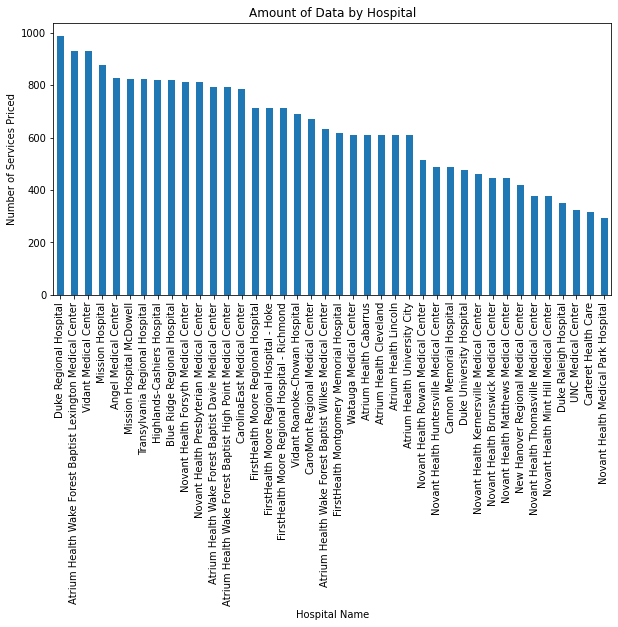

In [20]:
# looking for the amount of data relevant to each hospital
df['hospital_name'].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Amount of Data by Hospital")
plt.ylabel('Number of Services Priced')
plt.xlabel('Hospital Name');

Text(0.5, 1.0, 'affiliation')

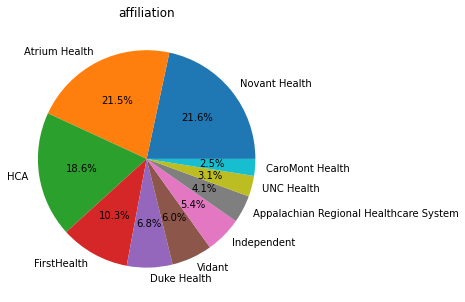

In [21]:
# looking for the split of hospital groups (if affiliated) in the dataset
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=df['affiliation'].value_counts(), 
       labels=df['affiliation'].value_counts().index,
       autopct='%1.1f%%')
ax.set_title('affiliation')

Text(0.5, 1.0, 'state')

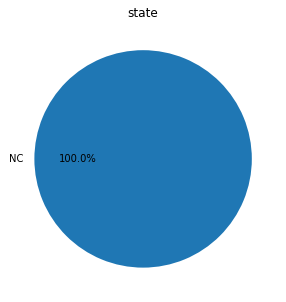

In [22]:
# looking for the state location split of the hospitals
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=df['state'].value_counts(), 
       labels=df['state'].value_counts().index,
       autopct='%1.1f%%')
ax.set_title('state')

In [23]:
# looking at the unique NC cities in the dataset
print(df['city'].unique())

['Clinton' 'Gastonia' 'Raleigh' 'Durham' 'Supply' 'Charlotte'
 'Winston-Salem' 'Huntersville' 'Kernersville' 'Matthews' 'Mint Hill'
 'Salisbury' 'Thomasville' 'Greenville' 'Ahoskie' 'Pinehurst' 'Raeford'
 'Rockingham' 'Franklin' 'Spruce Pine' 'Highlands' 'Asheville' 'Marion'
 'Brevard' 'New Bern' 'High Point' 'Lexington' 'North Wilkesboro' 'Troy'
 'Morehead City' 'Linville' 'Boone' 'Concord' 'Shelby' 'Lincolnton'
 'Bermuda Run' 'Mount Airy' 'Chapel Hill' 'Wilmington' 'Kinston' 'Burgaw'
 'Hendersonville' 'Lenoir' 'Rocky Mount' 'Goldsboro' 'Eden' 'Smithfield'
 'Siler City']


Text(0.5, 1.0, 'critical_access_ind')

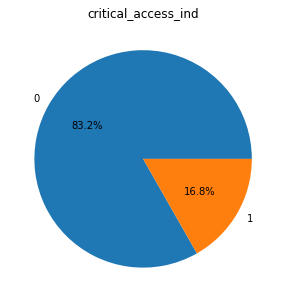

In [24]:
# looking for the split of critical access hospitals
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=df['critical_access_ind'].value_counts(), 
       labels=df['critical_access_ind'].value_counts().index,
       autopct='%1.1f%%')
ax.set_title('critical_access_ind')

In [25]:
# looking for which hospitals are critical access hospitals & where they're located
df[['hospital_id', 'hospital_name', 'city', 'critical_access_ind']].groupby(['hospital_id', 'hospital_name', 'city'], as_index=False).mean().sort_values(by='critical_access_ind', ascending=False)

,hospital_id,hospital_name,city,critical_access_ind
40,86,Pender Memorial Hospital,Burgaw,1.0
28,70,Transylvania Regional Hospital,Brevard,1.0
4,12,Cannon Memorial Hospital,Linville,1.0
25,67,Highlands-Cashiers Hospital,Highlands,1.0
24,66,Blue Ridge Regional Hospital,Spruce Pine,1.0
23,65,Angel Medical Center,Franklin,1.0
43,92,Chatham UNC Health Care,Siler City,1.0
19,61,FirstHealth Montgomery Memorial Hospital,Troy,1.0
39,83,Novant Health Thomasville Medical Center,Thomasville,0.0
32,76,Novant Health Huntersville Medical Center,Huntersville,0.0


Text(0.5, 1.0, 'vocabulary_id')

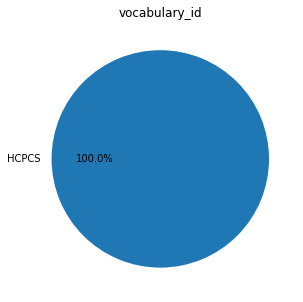

In [26]:
# looking for the split of the list type
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=df['vocabulary_id'].value_counts(), 
       labels=df['vocabulary_id'].value_counts().index,
       autopct='%1.1f%%')
ax.set_title('vocabulary_id')

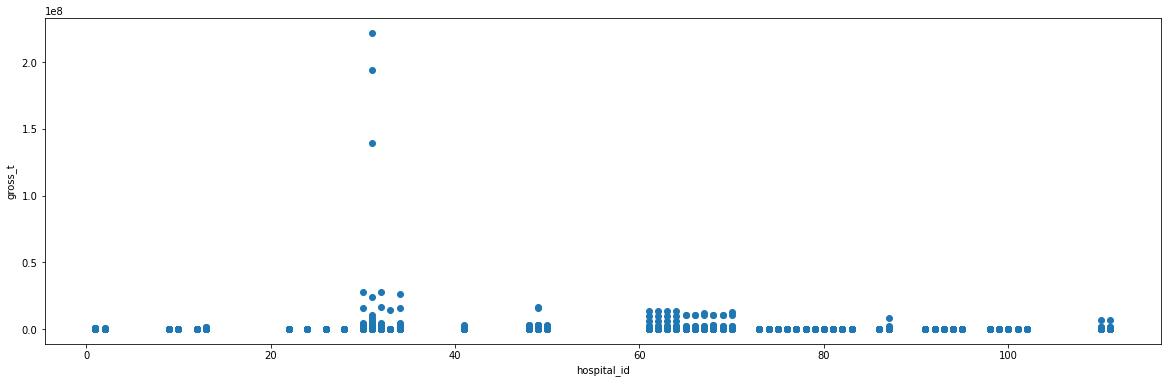

In [27]:
# seeing the distribution of gross prices by hospital
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(df['hospital_id'], df['gross_t'])
ax.set_xlabel('hospital_id')
ax.set_ylabel('gross_t')
plt.show()

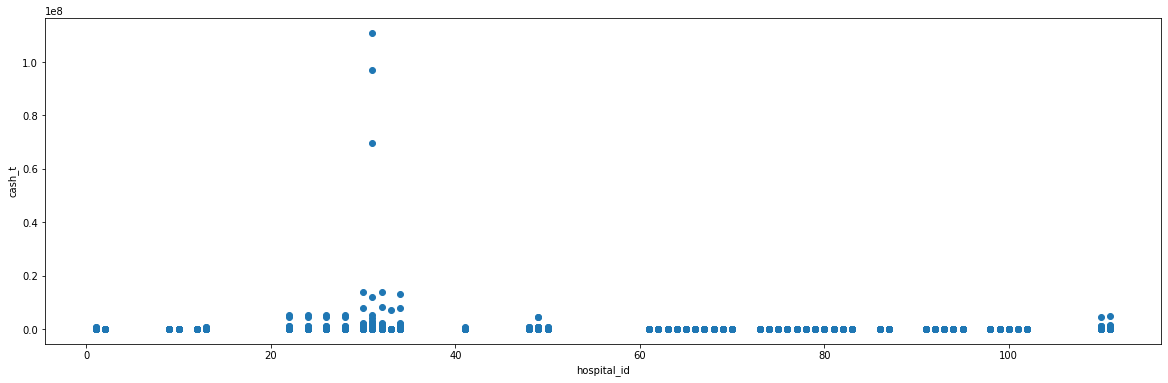

In [28]:
# seeing the distribution of cash prices by hospital
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(df['hospital_id'], df['cash_t'])
ax.set_xlabel('hospital_id')
ax.set_ylabel('cash_t')
plt.show()

Just visually, it seems like the same hospitals that have some of the highest gross costs also have some of the highest cash costs. It's worth looking into what kinds of treatments have these prices, because maybe they are not offered at many hospitals. Highly specialized services would justify the kinds of outliers that we're seeing above.

In [1]:
# seeing the distribution of gross prices by affiliation
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(df['concept_id'], df['gross_t'])
ax.set_xlabel('concpet_id')
ax.set_ylabel('gross_t')
plt.show()

NameError: ignored

In [ ]:
# seeing the distribution of gross prices by concept id
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(df['affiliation'], df['gross_t'])
ax.set_xlabel('affiliation')
ax.set_ylabel('gross_t')
plt.show()

In [28]:
# viewing all service concepts in the dataset by gross cost
df[['concept_code', 'concept_name', 'gross_t']].groupby(['concept_code', 'concept_name'], as_index=False).mean().sort_values(by='gross_t', ascending=False)

,concept_code,concept_name,gross_t
324,C1713,Anchor/screw for opposing bone-to-bone or soft...,1.018429e+07
366,C1776,Joint device (implantable),9.735254e+06
389,C1821,Interspinous process distraction device (impla...,5.197893e+06
396,C1874,"Stent, coated/covered, with delivery system",1.883727e+06
2350,Q2042,"Tisagenlecleucel, up to 600 million car-positi...",1.857540e+06
...,...,...,...
560,D0475,DECALCIFICATION PROCEDURE,0.000000e+00
559,D0470,DIAGNOSTIC CASTS,0.000000e+00
558,D0320,TEMPOROMANDIBULAR JOINT ARTHROGRAM,0.000000e+00
557,D0274,BITEWINGS-FOUR FILMS,0.000000e+00


In [29]:
# viewing all service concepts in the dataset by cash cost
df[['concept_code', 'concept_name', 'cash_t']].groupby(['concept_code', 'concept_name'], as_index=False).mean().sort_values(by='cash_t', ascending=False)

,concept_code,concept_name,cash_t
324,C1713,Anchor/screw for opposing bone-to-bone or soft...,4.301376e+06
366,C1776,Joint device (implantable),3.701696e+06
389,C1821,Interspinous process distraction device (impla...,2.591473e+06
2350,Q2042,"Tisagenlecleucel, up to 600 million car-positi...",9.287700e+05
396,C1874,"Stent, coated/covered, with delivery system",7.591802e+05
...,...,...,...
569,D2140,AMALGAM-ONE SURFACE,0.000000e+00
570,D2150,AMALGAM-TWO SURFACES,0.000000e+00
571,D2161,AMALGAM-FOUR OR MORE SURFACES,0.000000e+00
572,D2330,RESIN-ONE SURFACE,0.000000e+00


From the above tables, we can see that they are fairly consistent with each other. Code C1713, C1776, and C1821 are in the exact same ranking, with codes C1874 and 2024 swapped and off by only 1. The lower cost items are not very consistent in terms of ranking, but they all have a value of 0 so I attribute the differences to that.

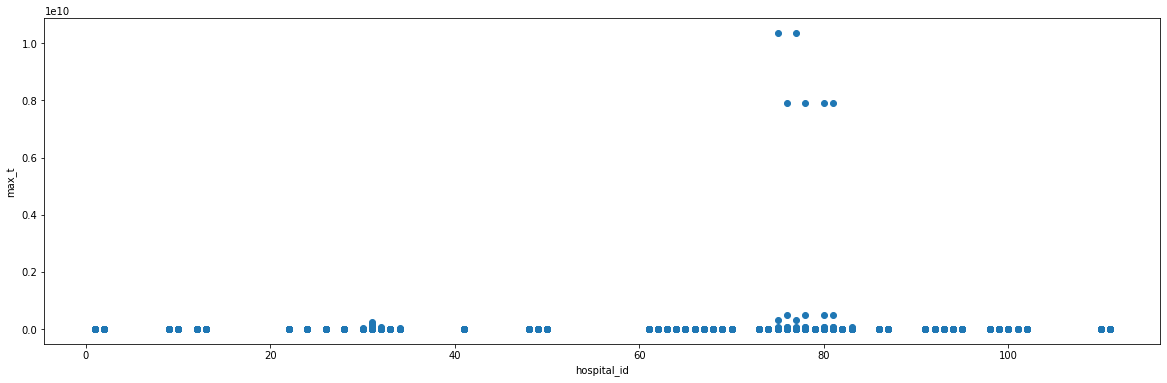

In [30]:
# seeing the distribution of max prices by hospital
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(df['hospital_id'], df['max_t'])
ax.set_xlabel('hospital_id')
ax.set_ylabel('max_t')
plt.show()

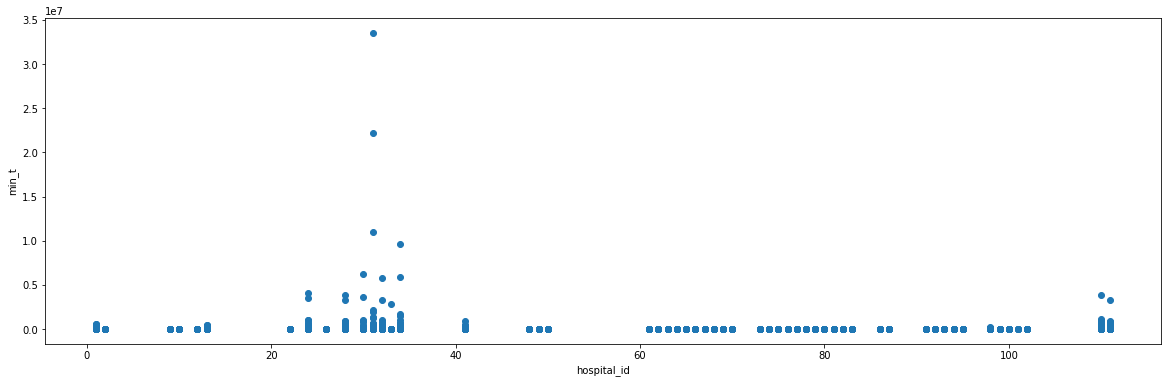

In [31]:
# seeing the distribution of min prices by hospital
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(df['hospital_id'], df['min_t'])
ax.set_xlabel('hospital_id')
ax.set_ylabel('min_t')
plt.show()

Alternatively, the max costs and min costs don't seem to show a direct correlation, as gross costs and cash costs did. 

In [32]:
# viewing all service concepts in the dataset by max cost
df[['concept_code', 'concept_name', 'max_t']].groupby(['concept_code', 'concept_name'], as_index=False).mean().sort_values(by='max_t', ascending=False)

,concept_code,concept_name,max_t
259,A9543,"Yttrium y-90 ibritumomab tiuxetan, therapeutic...",2.757919e+09
302,A9604,"Samarium sm-153 lexidronam, therapeutic, per t...",1.483159e+08
258,A9542,"Indium in-111 ibritumomab tiuxetan, diagnostic...",3.012995e+07
294,A9586,"Florbetapir f18, diagnostic, per study dose, u...",1.869802e+07
283,A9572,"Indium in-111 pentetreotide, diagnostic, per s...",1.529277e+07
...,...,...,...
180,A6402,"Gauze, non-impregnated, sterile, pad size 16 s...",0.000000e+00
1005,J1260,"Injection, dolasetron mesylate, 10 mg",0.000000e+00
178,A6260,"Wound cleansers, any type, any size",0.000000e+00
174,A6256,"Specialty absorptive dressing, wound cover, st...",0.000000e+00


In [33]:
# viewing all service concepts in the dataset by min cost
df[['concept_code', 'concept_name', 'min_t']].groupby(['concept_code', 'concept_name'], as_index=False).mean().sort_values(by='min_t', ascending=False)

,concept_code,concept_name,min_t
324,C1713,Anchor/screw for opposing bone-to-bone or soft...,1.622232e+06
366,C1776,Joint device (implantable),1.111136e+06
389,C1821,Interspinous process distraction device (impla...,4.464259e+05
2350,Q2042,"Tisagenlecleucel, up to 600 million car-positi...",3.845108e+05
396,C1874,"Stent, coated/covered, with delivery system",2.601517e+05
...,...,...,...
2074,L6611,"Addition to upper extremity prosthesis, extern...",0.000000e+00
2077,L6620,"Upper extremity addition, flexion/extension wr...",0.000000e+00
1136,J2510,"Injection, penicillin g procaine, aqueous, up ...",0.000000e+00
2080,L6624,"Upper extremity addition, flexion/extension an...",0.000000e+00


Again, not too many similarities here. Although the highest max cost does make sense since that is also the highest gross and cash cost.

c. Feature Encoding

In [34]:
# converting each city into an integer
enum = {}
for i in range(len(df['city'].unique())):
  enum.setdefault(df['city'].unique()[i], i)

df['city'] = df['city'].map(enum)

# converting each affiliation group into an integer
df['affiliation'] = df['affiliation'].map({ 'Independent': 0, 'CaroMont Health': 1,  'Duke Health': 2, 'Novant Health': 3,
                                           'Vidant': 4, 'FirstHealth': 5, 'HCA': 6, 'Atrium Health': 7, 
                                           'Appalachian Regional Healthcare System': 8, 'UNC Health': 9})

# dropping "vocabulary_id" and "state" columns because they're all the same value
df.drop(['vocabulary_id'], axis=1, inplace=True)
df.drop(['state'], axis=1, inplace=True)

# dropping following columns because either not relevant information or can be found from IDs
df.drop(['hospital_npi'], axis=1, inplace=True)
df.drop(['concept_code'], axis=1, inplace=True)
df.drop(['concept_name'], axis=1, inplace=True)
df.drop(['hospital_name'], axis=1, inplace=True)

# viewing the first few rows of the data
print(df.shape)
df.head()

(26781, 9)


,concept_id,hospital_id,city,critical_access_ind,affiliation,cash_t,gross_t,max_t,min_t
0,40218804,10,0,0,0,74.20,106.00,97.52,67.52
1,40218804,41,1,0,1,63.75,182.15,173.04,23.00
2,40218804,48,2,0,2,39.20,140.00,106.40,0.00
3,40218804,49,3,0,2,39.20,140.00,103.88,0.00
4,40218804,50,3,0,2,39.20,140.00,226.07,0.00


d. Features Correlation

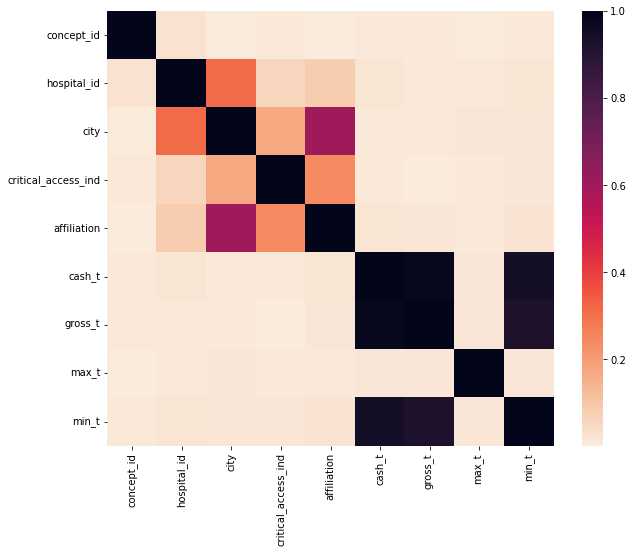

In [35]:
# seeing how our features correlate with each other
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr().abs(),annot=False, ax=ax, cmap='rocket_r')

In [36]:
# seeing how our features correlate with "gross_t"
df.corr()['gross_t'].sort_values(ascending=False)

gross_t                1.000000
cash_t                 0.982778
min_t                  0.925919
affiliation            0.016746
max_t                  0.016131
city                   0.011458
critical_access_ind   -0.002066
concept_id            -0.009570
hospital_id           -0.013112
Name: gross_t, dtype: float64

In [37]:
# seeing how our features correlate with "cash_t"
df.corr()['cash_t'].sort_values(ascending=False)

cash_t                 1.000000
gross_t                0.982778
min_t                  0.948115
affiliation            0.018474
max_t                  0.016535
city                   0.012931
concept_id            -0.007817
critical_access_ind   -0.010968
hospital_id           -0.019083
Name: cash_t, dtype: float64

In [38]:
# seeing how our features correlate with "max_t"
df.corr()['max_t'].sort_values(ascending=False)

max_t                  1.000000
cash_t                 0.016535
gross_t                0.016131
min_t                  0.015274
hospital_id            0.011610
concept_id            -0.004162
critical_access_ind   -0.007390
affiliation           -0.012405
city                  -0.015637
Name: max_t, dtype: float64

In [39]:
# seeing how our features correlate with "min_t"
df.corr()['min_t'].sort_values(ascending=False)

min_t                  1.000000
cash_t                 0.948115
gross_t                0.925919
affiliation            0.022560
max_t                  0.015274
city                   0.015153
concept_id            -0.010029
critical_access_ind   -0.014612
hospital_id           -0.020043
Name: min_t, dtype: float64

The most notable observation here is that "max_t" is so drastically less correlated with "gross_t", "cash_t", and "min_t" (which all have a correlation coefficient of > 0.9 with each other). Their correlation coefficient is roughly 0.7 more than the correlation "max_t" has with any of them, which is strange. This might possibly indicate a significant outlier in the values of "max_t".

# Task 5: Neural Network and Regression Models


In [61]:
# partitioning via a train-dev-test split

X = df.drop(['cash_t', 'gross_t', 'min_t', 'max_t'], axis=1)   # independent variables
y = df.min_t                     # dependent/target variable

# dividing the data into 'train', 'test', and 'dev' sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)          # 80% for training
#X_test, X_dev, y_test, y_dev = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)    # 10% for dev and 10% for test

# viewing the shape of each
print("x temp shape: ", X_train.shape)
print("y test shape: ", y_test.shape)

x temp shape:  (21424, 5)
y test shape:  (5357,)


In [122]:
y_train.shape

(21424,)

In [62]:
#scaling data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
y_train=np.reshape(y_train.values, (-1,1))
y_test=np.reshape(y_test.values, (-1,1))

print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)
print(scaler_x.fit(X_test))
xval_scale=scaler_x.transform(X_test)
print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)
print(scaler_y.fit(y_test))
yval_scale=scaler_y.transform(y_test)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [63]:
#checkpoint for saving best model
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [75]:
#Creating deep neural network
def create_model(X):

  model = Sequential()
  model.add(Dense(X.shape[1], input_dim=X.shape[1],
                  kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, activation='linear'))
  model.summary()

  return model

In [79]:
#compliling model
msle = MeanSquaredLogarithmicError()
model = create_model(X_train)
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=0.01), 
    metrics=[msle]
)
# train the model
history = model.fit(
    xtrain_scale, 
    y_train, 
    epochs=10, 
    batch_size=32,
    validation_split=0.2
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 5)                 30        
                                                                 
 dropout_16 (Dropout)        (None, 5)                 0         
                                                                 
 dense_33 (Dense)            (None, 256)               1536      
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 256)               65792     
                                                                 
 dense_35 (Dense)            (None, 1)                 257       
                                                                 
Total params: 67,615
Trainable params: 67,615
Non-trai

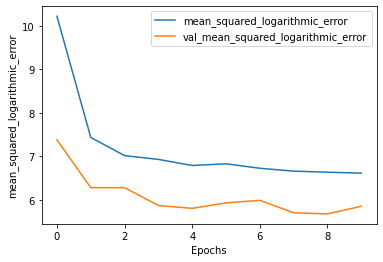

In [80]:
def plot_metrics(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()

plot_metrics(history, 'mean_squared_logarithmic_error')

In [83]:
#predictions
from sklearn.metrics import mean_squared_error
pred_test= (model.predict(xval_scale))
pred_test = scaler_y.inverse_transform(pred_test)
print(np.sqrt(mean_squared_error(y_test,pred_test)))


168/168 [==============================] - 0s 3ms/step
2038866873.0107987


In [84]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pickle

# Instantiate model with 100 decision trees
rf_base = RandomForestRegressor(n_estimators = 100, random_state = 42,oob_score = True)
rf_base.fit(X_train, y_train)


#save the model output
pickle.dump(rf_base, open("basemodel_rf", 'wb'))

#load the saved model and predict on the test data
basedmodel_rf = pickle.load(open("basemodel_rf", 'rb'))


#validate the accuracy of the base model
#compare the model accuracies
Y_test_predict_base = basedmodel_rf.predict(X_test)
print("Base model accuracy:",np.sqrt(mean_squared_error(y_test, Y_test_predict_base)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Base model accuracy: 171313.9919606819


In [89]:
from xgboost import XGBRegressor
import math

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb_model.fit(X_train, y_train)
testpred = xgb_model.predict(X_test)
test_mse = math.sqrt(mean_squared_error(y_test, testpred))
print(test_mse)

173665.98726328058


In [90]:
np.mean(y_test)

8398.213194894392

In [ ]:
def test_model(model, test, prediction, epochs, callbacks_list):
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=32, validation_split=0.2, verbose=1, callbacks = callbacks_list)

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()

    prediction = model.predict(X_test)
    prediction = sc.inverse_transform(prediction)

    error = mean_squared_error(test, prediction)
    rmse = mean_squared_error(test, prediction)**0.5
    print('Test MSE: %.3f' % rmse)